# Assignment - 5

## Donal Loitam -  AI21BTECH11009

In [1]:
%matplotlib inline

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

## 1. Optimal Decorrelating Transform
1. Implement principal component analysis (PCA) to decorrelate an image. Divide the image into non-overlapping 8 × 8
patches and vectorize the patches into 64-dimensional vectors. Find the covariance matrix using all the image patches.
Ensure that the data is zero-mean (feature-wise). Reconstruct the image at three different “compression” levels of 48,
32 and 16 dimensions and display it. Again, be sure to add the mean back. Is the PCA effective in decorrelating
images? (10)

In [2]:
def decorrelate_img_using_pca(img, n_dims):
    """
        Decorrelates the input image using Principal Component Analysis (PCA). Patch size here is 8 x 8
   
        Args
            img:  image to be decorrelated.
            n_dims: The number of dimensions to be retained.

        Returns
            final_img: The final decorrelated image.
                                                                                            """
    
    try:
        M, N = img.shape
    except:
        M, N, C = img.shape
        
    
    # A list to store the vectorised patches
    patches = []
    
    M = M - M % 8
    N = N - N % 8   
    # Divide the image into patches, Assume M, N to be multiples of 8
    for x in range(N // 8):
        for y in range(M // 8):
            patch = img[y*8 : (y+1)*8, x*8 : (x+1)*8]
            patch_vector = patch.flatten()
            patches.append(patch_vector)
           
    # As discussed in class, each patch vector is made column vector
    patch_arr = np.array(patches).T     
    feature_means = np.mean(patch_arr, axis = 1)    # mean of each features to be subtracted so as to make zero-mean
    zero_mean_patch_arr = patch_arr.T - feature_means
    zero_mean_patch_arr = zero_mean_patch_arr.T
    mean_patches = patch_arr.mean(1)
    
    # Calculate the covariance matrix using all the image patches(zero mean)
    cov_matrix = np.cov(zero_mean_patch_arr)
    
    # Since covariance matrix is symmetric
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    top_eigen_vectors = eigenvectors[:, np.argsort(eigenvalues)[::-1][:n_dims]]
      
    reduced_dim_img = np.dot(top_eigen_vectors.T, zero_mean_patch_arr)
    reconstructed_img = np.dot(top_eigen_vectors, reduced_dim_img)
    
    mean_added_reconstructed_img = reconstructed_img.T + feature_means
    
    # Making the vectors back into patches
    final_img = np.zeros((M , N))

    count = 0
    for y in range(0 , M//8):
        for x in range(0 , N//8):
            vector = mean_added_reconstructed_img[count , :]
            final_img[y*8 : (y+1)*8, x*8 : (x+1)*8] = vector.reshape(8 , 8)   # since 8 × 8 patches 
            count += 1
    
    return final_img.T

Read the image, reduce it to single channel and clip it 

In [3]:
lighthouse = plt.imread("lighthouse.png")
single_channel_lighthouse = np.mean(lighthouse, axis=2)
print(single_channel_lighthouse.shape)

lighthouse_clipped = np.clip(np.int64(single_channel_lighthouse * 255) , 0 , 255) 
print(lighthouse_clipped.shape)

M , N = lighthouse_clipped.shape

(691, 691)
(691, 691)


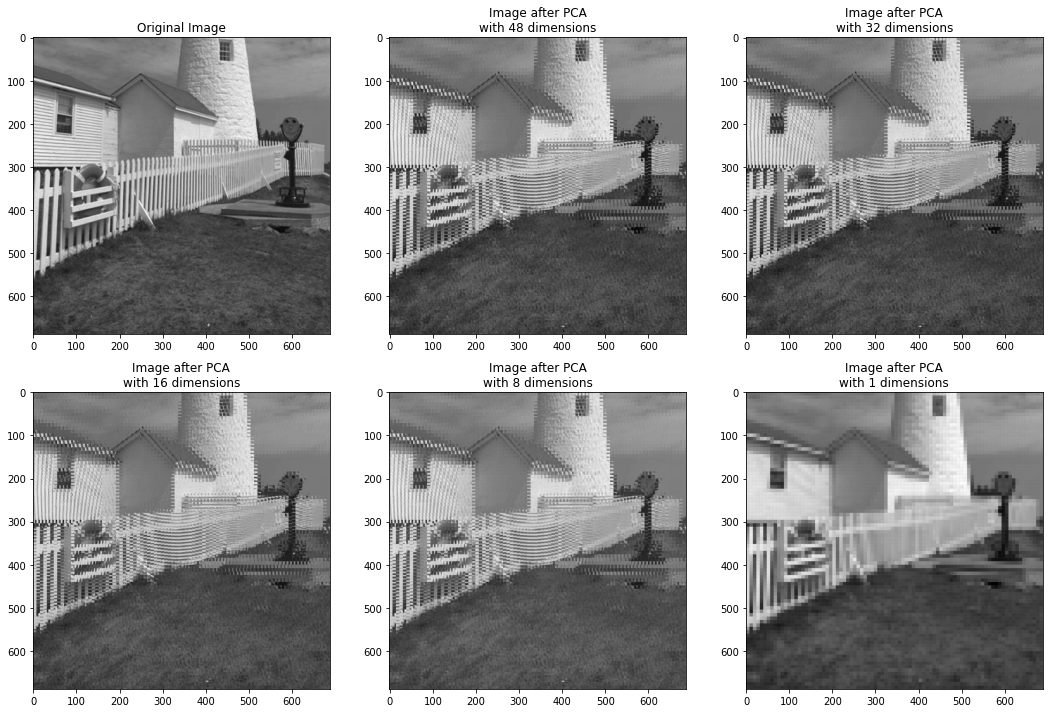

In [4]:
def plot_pca_compression(image, title, pca_dimensions, index):
    plt.subplot(2, 3, index)
    plt.imshow(image, cmap='gray')
    plt.title(title + f"\nwith {pca_dimensions} dimensions")

    
# Plotting the images
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(lighthouse_clipped[:M - M % 8, :N - N % 8], cmap="gray")
plt.title("Original Image")


# PCA Compression
dimensions = [48, 32, 16, 8, 1]

for i, pca_dims in enumerate(dimensions):
    pca_image = decorrelate_img_using_pca(lighthouse_clipped, pca_dims)
    plot_pca_compression(pca_image, "Image after PCA", pca_dims, i + 2)

plt.tight_layout()
plt.show()


## 2 Discrete Cosine Transform
Write a program to implement a JPEG-like image encoder using the following steps.

Encoder:
1. Divide the image into non-overlapping blocks of 8×8 pixels.
2. Apply the Type-II DCT to each of the blocks (defined in the slides).
3. Divide each block by the quantization matrix. Look up the quantization matrix Q in the slides. Verify that you are left with sparse coefficients at this point.

Decoder:

1. Multiply each block with the inverse Q matrix.
2. Apply the Type-II IDCT to each block.
3. Put the sub-blocks together to generate the decoded estimate of the original image.


Display the original and “lossy-compressed” images. Is the DCT effective for image compression?

In [5]:
def coefficient_C(u):
    return 1 / math.sqrt(2) if u == 0 else 1

def calculate_cos(u, i, M):
    return math.cos((2 * i + 1) * u * math.pi / (2 * M))


def DCT(img):
    """
        Computes the Discrete Cosine Transform (DCT) of an input image.

    Args:
        img: 2D np array which is the input image.

    Returns:
        dct_I_hat: 2D numpy array containing the DCT coefficients of the input image.
                                                                                                """
   
    M, N = img.shape
    dct_I_hat = np.zeros((M, N), dtype= np.float64)
    C_matrix = np.array([[coefficient_C(i) * coefficient_C(j) for j in range(N)] for i in range(M)])

    for u in range(M):
        for v in range(N):
            # Find dct_I_hat[u, v], first design the matrix of cos
            cosine_matrix = np.array([[calculate_cos(u, i, M) * calculate_cos(v, j, N) for j in range(N)] for i in range(M)])
            dct_I_hat[u, v] = np.sum(cosine_matrix * img) 
                   
    dct_I_hat = dct_I_hat * C_matrix
    
    return dct_I_hat * (4 / (N * M))


 
def IDCT(dct_img):
    """
        Computes the Inverse Discrete Cosine Transform (IDCT) of a given input DCT image(coefficients).

    Args:
        dct_img: 2D np array which are the DCT coefficients of an image.

    Returns:
        img_idct: 2D np array containing the reconstructed image from DCT coefficients.
                                                                                                    """
    
    M, N = dct_img.shape
    img_idct = np.zeros((M, N), dtype=np.float64)
    C_matrix = np.array([[coefficient_C(u) * coefficient_C(v) for v in range(N)] for u in range(M)])

    for i in range(M):
        for j in range(N):
            # Find img_idct[u, v], first design the matrix of cos
            cosine_matrix = np.array([[calculate_cos(u, i, M) * calculate_cos(v, j, N) for v in range(N)] for u in range(M)])
            cosine_matrix = cosine_matrix * C_matrix
            img_idct[i, j] = np.sum(cosine_matrix * dct_img)
    
    return img_idct
    
    

In [6]:
def jpeg_like_image_encoder(img):
    """
        Encodes an image using a JPEG-like compression scheme.
                                                                
        Args: 
            img: Input grayscale imagee as 2D array
        
        Returns:
            tuple: (Encoded image in the frequency domain(DCT coefficients), the Quantized encoded image)
                                                                                                                """
    
    M, N = img.shape
    M = math.floor(M / 8) * 8
    N = math.floor(N / 8) * 8
    
    Q_matrix = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56 ],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,103,99]])
    
    img_DCT = np.zeros((M , N))
    img_encoded = np.zeros((M , N) , dtype = np.int64)
     
    # 1. Divide the image into non-overlapping blocks of 8×8 pixels.
    # 2. Apply the Type-II DCT to each of the blocks (defined in the slides).
    # 3. Divide each block by the quantization matrix. Look up the quantization matrix Q in the slides. 
    blocks = []   
    for j in range(N//8):
        for i in range(M//8):
            block = img[i*8:(i+1)*8, j*8:(j+1)*8]
            img_DCT[i*8:(i+1)*8, j*8:(j+1)*8] = DCT(block)
            img_encoded[i*8:(i+1)*8, j*8:(j+1)*8] = np.round(img_DCT[i*8:(i+1)*8, j*8:(j+1)*8] / Q_matrix)
               
    return img_DCT, img_encoded



def jpeg_like_image_decoder(img):
    """
        Decodes an image encoded using a JPEG-like compression style.

    Args:
        img : quantised input encoded image 

    Returns:
        numpy array: the decoded grayscale image (2D array).
                                                                                                                    """
    
    M, N = img.shape
    M = math.floor(M / 8) * 8
    N = math.floor(N / 8) * 8
    
    Q_matrix = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56 ],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,103,99]])
    
    img_decoded = np.zeros((M , N))
     
    # 1. Multiply each block with the inverse Q matrix.
    # 2. Apply the Type-II IDCT to each block.
    # 3. Put the sub-blocks together to generate the decoded estimate of the original image
    blocks = []   
    for j in range(N//8):
        for i in range(M//8):
            block = img[i*8:(i+1)*8, j*8:(j+1)*8]
            restored = np.multiply(block , Q_matrix)
            img_decoded[i*8:(i+1)*8, j*8:(j+1)*8] = IDCT(restored)
               
    return img_decoded

In [7]:
dct , encoded_img = jpeg_like_image_encoder(lighthouse_clipped)

# Calculate the number of zeros in the encoded image, total size of the image
total_size = encoded_img.size
num_zeros = total_size - np.count_nonzero(encoded_img)
# Sparsity
sparsity = num_zeros / total_size

print("The number of zeros in the encoded image is {}, while the total size of the image is {}".format(num_zeros, total_size))
print("Sparsity of the encoded image is {:.8f}".format(sparsity))
print(f"\nA sparsity of {round(sparsity, 8)}(or {round(sparsity, 8)*100}%) indicates that only a small portion of the coefficients in the encoded image are non-zeros, while the majority are zero values.")

The number of zeros in the encoded image is 455227, while the total size of the image is 473344
Sparsity of the encoded image is 0.96172551

A sparsity of 0.96172551(or 96.172551%) indicates that only a small portion of the coefficients in the encoded image are non-zeros, while the majority are zero values.


In [8]:
decoded_img = jpeg_like_image_decoder(encoded_img)

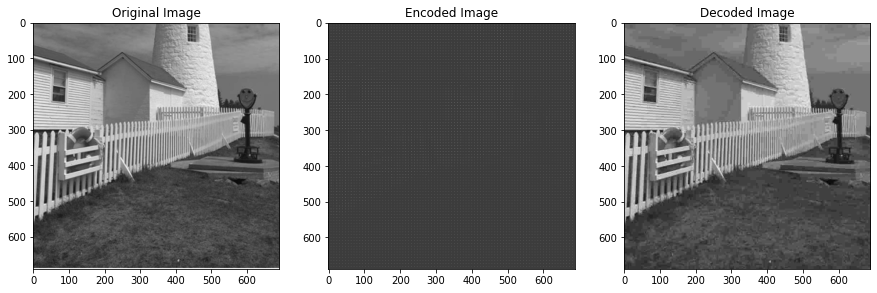

In [9]:
plt.figure(figsize = (15 , 15))
plt.subplot(1 , 3 , 1)
plt.imshow(lighthouse_clipped , cmap = 'gray')
plt.title('Original Image')

plt.subplot(1 , 3 , 2)
plt.imshow(encoded_img , cmap = 'gray')
plt.title('Encoded Image')

plt.subplot(1 , 3 , 3)
plt.imshow(decoded_img , cmap = 'gray')
plt.title('Decoded Image')

plt.show()

### ANSWER : Effectiveness of DCT compression -
1. **High Sparsity, Efficient Compression** : Yes, the high sparsity of the encoded image suggests that DCT compression is quite effeccient. This high sparsity indicates that much of the image information is concentrated in a small subset of coefficients.


2. **Minimal Loss, Preserved Quality**: Despite compression, the decoded image closely resembles the original, demonstrating minimal loss of visual quality

## 3 Motion Estimation
In this problem you will implement the most critical part of the video codec – the motion estimator. Do the following:
1. Use the 3-step search to find motion vectors (check slides for description). (10)

    - Use mean absolute distance (MAD) as your metric.
    - Step 1: Search at 8 location ±4 pixels around current macroblock including (0, 0) (relative to current macroblock).
    - Step 2: search at 8 location ±2 pixels around best match location in Step 1 including best match location.
    - Step 3: search at 8 location ±1 pixels around best match location in Step 2 including best match location.

In [10]:
def calculate_mean_MAD(block1, block2):
    return np.sum(np.abs(block1 - block2))


def find_best_match(center, current_block, frame2, step_size):
    
    # Initialise min with infinity
    min_MAD = float('inf')
    
    best_point = center
    search_area = [(center[0] + x, center[1] + y) for x in range(-step_size, step_size+1, step_size) for y in range(-step_size, step_size+1, step_size)]

    for coordinate in search_area:
        x, y = coordinate
        
        try:    # try if we can extract 16 x 16 blocks
            block2 = frame2[x-8:x+8, y-8:y+8]
            MAD_score = calculate_mean_MAD(current_block, block2)
            if MAD_score < min_MAD:
                best_point = coordinate
                min_MAD = MAD_score
            
        except:  # if not i.e 16x16 block does not exist around that point(as pointed out by sir)
            continue
                
    return best_point
                

    
def three_step_search(frame1, frame2):
    # Assume One channel input
    M, N  = frame1.shape
    # Make the shape a multiple of 16, if not already(for simplicity)
    M = math.floor(M / 16) * 16
    N = math.floor(N / 16) * 16
    motion_vectors = {}
    step_sizes = [4, 2, 1]
    
    for i in range(0, M//16):
        for j in range(0, N//16):
            # Extract the center point and the current macro block centered around it
            center = (16*i + 8, 16*j + 8)
            current_block = frame1[(center[0]-8):(center[0]+8), (center[1]-8):(center[1]+8)]
            
            best_match1 = find_best_match(center, current_block, frame2, step_sizes[0])
            best_match2 = find_best_match(best_match1, current_block, frame2, step_sizes[1])
            best_match3 = find_best_match(best_match2, current_block, frame2, step_sizes[2])
            
            # Calculate motion vector
            motion_vector = (best_match3[0] - center[0], best_match3[1] - center[1])
            motion_vectors[center] = motion_vector
    
    return motion_vectors
    
    
def generate_predicted_frame(frame1, motion_vectors):
    M, N = frame1.shape
    predicted_frame = np.zeros_like(frame1)
    
    for center, motion_vector in motion_vectors.items():
        i, j = center
        x, y = motion_vector
        # Ensure indices are within bounds
        if i+x-8 >= 0 and i+x+8 <= M and j+y-8 >= 0 and j+y+8 <= N:
            predicted_frame[i-8:i+8, j-8:j+8] = frame1[i+x-8:i+x+8, j+y-8:j+y+8]

    return predicted_frame



In [11]:
# importing the images
frame1 = plt.imread('first_frame.png')
print(frame1.shape)

# importing the images
frame2 = plt.imread('second_frame.png')
print(frame2.shape)

(144, 176)
(144, 176)


#### Questions
2. Plot the motion vector at each macroblock. You can use the arrow function in matplotlib. (1)
3. Generate the motion compensated predicted frame using the motion vectors and the first frame. (3)
4. Compute the error between the second frame and its motion compensated predicted version and display it. (1)

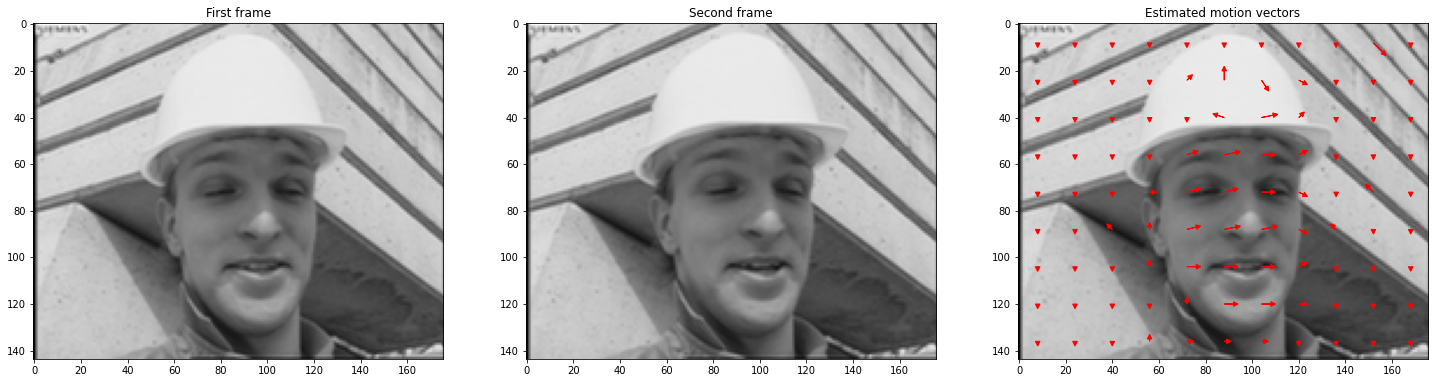

In [12]:
plt.figure(figsize=(25, 12))

plt.subplot(1, 3, 1)
plt.imshow(frame1, cmap='gray')
plt.title("First frame")

plt.subplot(1, 3, 2)
plt.imshow(frame2, cmap='gray')
plt.title("Second frame")

plt.subplot(1, 3, 3)
motion_vectors = three_step_search(frame1, frame2)
plt.imshow(frame1, cmap='gray')

for center, motion_vector in motion_vectors.items():
    plt.arrow(center[1], center[0], motion_vector[1], motion_vector[0], head_width=2, head_length=2, fc='r', ec='r')

plt.gca().set_aspect('equal')
plt.title("Estimated motion vectors")
plt.show()

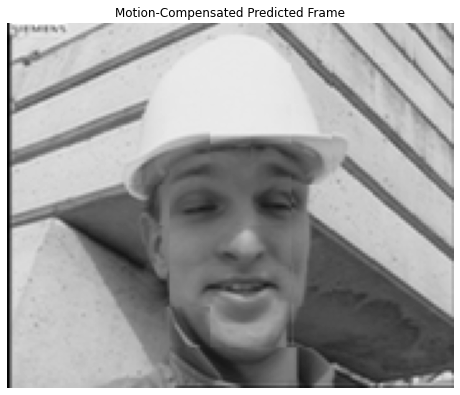

In [13]:
predicted_frame = generate_predicted_frame(frame1, motion_vectors)

plt.figure(figsize=(8, 7))
plt.imshow(predicted_frame, cmap='gray')
plt.title("Motion-Compensated Predicted Frame")
plt.axis('off')
plt.show()

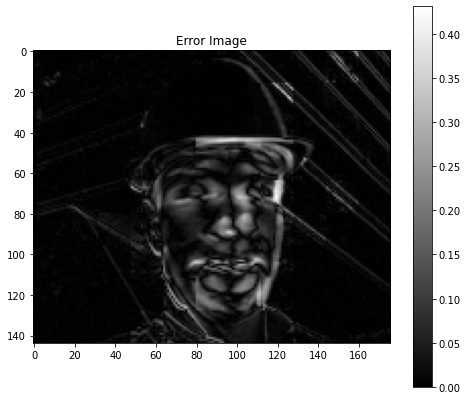

In [14]:
# Compute the error
error = np.abs(frame2 - predicted_frame)
plt.figure(figsize=(8, 7))
plt.imshow(error, cmap='gray')
plt.title('Error Image')
plt.colorbar()
plt.show()

- As we can see in the error image most of them are dark which means close to 0 value